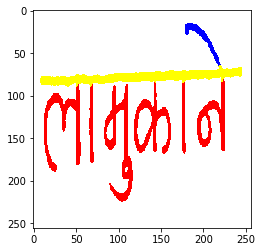

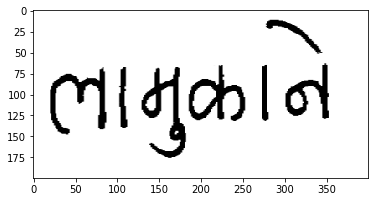

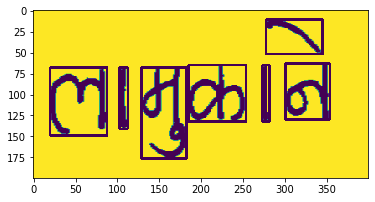

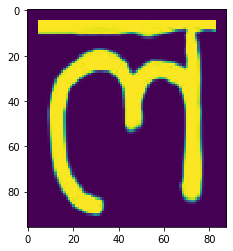

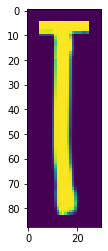

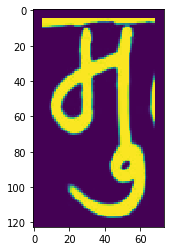

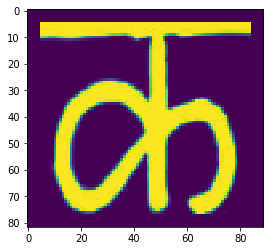

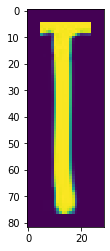

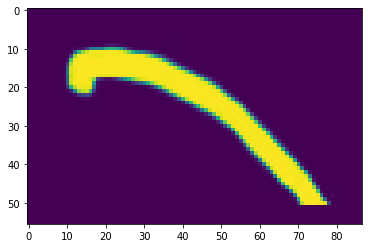

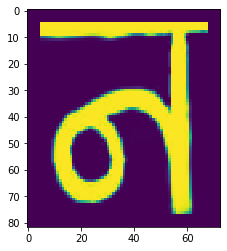

In [2]:
from utils import add_masks, crf
from config import imshape, model_name, n_classes
from models import preprocess_input, dice
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from utils import VideoStream
import cv2
import matplotlib.pyplot as plt
import numpy as np
import contextlib
import time
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

padding = 5
model = load_model(os.path.join('models', model_name +'1'+
                   '.model'), custom_objects={'dice': dice})

inimg = cv2.imread("Hello.jpg", 3)
copy1 = inimg.copy()
h=inimg.shape[0]
w=inimg.shape[1]
inimg=cv2.resize(inimg,(256,256))
ret,inimg = cv2.threshold(inimg, 100, 255, cv2.THRESH_BINARY)
im = inimg.copy()
tmp = np.expand_dims(im, axis=0)


roi_pred = model.predict(tmp)

roi_max = np.argmax(roi_pred.squeeze(), axis=2)
roi_pred = to_categorical(roi_max)
roi_mask = crf(roi_pred.squeeze(), im)
roi_mask = np.array(roi_mask, dtype=np.uint8)
roi_mask = cv2.addWeighted(im, 1.0, roi_mask, 1.0, 0)
plt.imshow(roi_mask)
plt.show()
roi_mask[np.where((roi_mask==[255,255,0]).all(axis=2))]=[255,255,255]
roi_mask[np.where((roi_mask == [255, 0, 0]).all(axis=2))] = [0, 0, 0]
roi_mask[np.where((roi_mask == [0, 0, 255]).all(axis=2))] = [0, 0, 0]
roi_mask = cv2.fastNlMeansDenoising(roi_mask, None, 20, 7, 21)
roi_mask=cv2.resize(roi_mask,(w//h*200,200))
plt.imshow(roi_mask)
plt.show()
words_list = []

edged = cv2.Canny(roi_mask, 30, 200)

contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
roi_mask = cv2.cvtColor(roi_mask, cv2.COLOR_BGR2GRAY)
img3 = roi_mask.copy()

sorted_contour_words = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
for i in sorted_contour_words:
                cv2.boundingRect(i)[0]
for word in sorted_contour_words:

                if cv2.contourArea(word) < 5:
                    continue
                x2, y2, w2, h2 = cv2.boundingRect(word)
                words_list.append([x2-padding,  y2-padding,  x2 + w2+padding,  y2 + h2])
                
                cv2.rectangle(img3, (x2, y2), (x2 + w2, y2 + h2), (0, 255, 100), 2)
plt.imshow(img3)
plt.show()
copy1 = cv2.resize(copy1,(w//h*200,200))
for i in range(0, len(words_list)):
            roi_9 = copy1[words_list[i][1]:words_list[i][3], words_list[i][0]:words_list[i][2]]
            roi_9 = cv2.bitwise_not(roi_9)
            roi_9 = cv2.cvtColor(roi_9,cv2.COLOR_BGR2GRAY)
            roi_9 = cv2.fastNlMeansDenoising(roi_9, None, 20, 20, 21)
            paddedImage = np.zeros((roi_9.shape[0] + padding*2, roi_9.shape[1] + padding*2))
            paddedImage[padding:-padding, padding:-padding] = roi_9
            cv2.imwrite("j/" + str(i) + ".png", paddedImage)
            
            plt.imshow(paddedImage)
            plt.show()


# Limitations
1. Minimum Rectangle, For Skewed writing (Due to lack of Time)
2. Need to make Recognition Model effiecient, effective and custom
3. Diaritics Segmentation(Ukar, Hrikar)(ML), Solved for others(Rule based) 
4. Ordering of the Segments
5. Compounded (Sankyuta) Characters (ML)
6. Connected Characters(While writing)
7. Effectiveness in denoising

